# Handle imports

In [120]:
from dotenv import load_dotenv
import os
import cassio
from uuid import uuid4

from typing import Literal,List,Annotated

from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage,trim_messages,AIMessage,HumanMessage,RemoveMessage


from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import add_messages

from typing_extensions import TypedDict

load_dotenv()

True

In [121]:
unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY') # Update to your API key

In [122]:
from langsmith import Client
client = Client()

# Connect to the database

In [123]:
# connection of Astra DB
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id = ASTRA_DB_ID
)

In [124]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [125]:
from langchain.vectorstores import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name = "CNM_test_table",
                               session=None,
                               keyspace=None)

In [126]:
recipe_retriever = astra_vector_store.as_retriever()
recipe_retriever.invoke("Give me a cookie recipe")

[Document(id='f221c87e5852447eaca5168f2e4349be', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-soft-chocolate-chip-cookies/print/39213', 'title': 'The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum'}, page_content='Keywords: chocolate chip cookies, best chocolate chip cookies, soft chocolate chip cookies, easy cookie recipe, small batch cookies\n\n\n\n\n\nDid you make this recipe?\nTag\xa0@pinchofyum\xa0on Instagram so we can admire your masterpiece!\xa0🌟\n\n\n\n\n\n\nFind it online: https://pinchofyum.com/the-best-soft-chocolate-chip-cookies'),
 Document(id='3af43e5c1fe84cd6a2ed6f96cd82bb7b', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-s

# Langgraph

### Datamodel

In [143]:
class GeneralRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["food","general"] = Field(
        ...,
        description="Given a user question choose to route it to general chat or a food"
    )

class ToolRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["meal_plan","recipe"] = Field(
        ...,
        description="Given a user question choose to route it to meal_plan or recipe"
    )

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: recent message history
        preferences: uses' food preferences
        documents: list of documents
        calorie_goal: user's calorie goal
    """
    messages: Annotated[list[AnyMessage], add_messages]
    documents: List[str]
    preferences: str
    calorie_goal: int

### LLM links

In [144]:
from langchain_groq import ChatGroq
# from google.colab import userdata
import os
groq_api_key = os.getenv('groq_api_key')
# print(groq_api_key)

In [145]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')
chat_llm = ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')

structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)


### Prompts

In [146]:
# General router Prompt
system = """You are an expert at routing a user question to a food or general.
The food can tools to take care of meal planning, recipe finding and creation.
Use the food for questions on these topics. Otherwise, use general."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_router = route_prompt | structured_llm_general_router

print(general_router.invoke({"messages": "what is stardew Valley"}))
print(general_router.invoke({"messages": "How to make a sweet dessert"}))

datasource='general'
datasource='food'


In [147]:
# tool router Prompt
system = """
You are an expert at routing a user message to a meal_plan or recipe.
the meal_plan has access to tools to generate a meal plan for your weight goals.
Use the meal_plan for questions on these topics. 
If the message has to do with finding or modifying a recipe, use recipe.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

tool_router = route_prompt | structured_llm_tool_router

print(tool_router.invoke({"messages": "how to make butter chicken"}))
print(tool_router.invoke({"messages": "help me plan the food for the week"}))

datasource='recipe'
datasource='meal_plan'


### nodes

In [ ]:
def trim(state):
    # response = trim_messages(
    #     state["messages"],
    #     strategy="last",
    #     token_counter=len, # each message will be counted as 1 token
    #     max_tokens=1,
    #     start_on="human",
    #     end_on=("human", "tool"),
    #     include_system=True,
    # )
    if len(state['messages']) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state['messages']}

In [149]:
def general_chat_bot(state):
    response = chat_llm.invoke(state["messages"])
    return {"messages": response}

In [150]:
def retrieve_recipes(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print("retrieved using the prompt: ",state["messages"][-1].content)
    
    response = recipe_retriever.invoke(state["messages"][-1].content)
    print("retrieved: ",response)
    return {"documents": response}

In [151]:
def general_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (GENERAL)---")
    message = state["messages"][-1].content
    print("message: ",message)
    
    source = general_router.invoke({"messages": message})
    print("source: ",source.datasource)
    if source.datasource == "general":
        print("---ROUTE QUESTION TO GENERAL CHAT---")
        return "general_chat_route"
    elif source.datasource == "food":
        print("---ROUTE QUESTION TO FOOD---")
        return "food_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [152]:
def tool_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (TOOLS)---")
    message = state["messages"][-1].content
    print("message: ",message)
    
    source = tool_router.invoke({"messages": message})
    print("source: ",source.datasource)
    if source.datasource == "meal_plan":
        print("---ROUTE QUESTION TO MEAL PLAN---")
        return "meal_plan_route"
    elif source.datasource == "recipe":
        print("---ROUTE QUESTION TO RECIPE---")
        return "recipe_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [153]:
def meal_planner(state):
    """"
    Create a meal plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the meal plan added
    
    """
    print("---MEAL PLANNER---")
    print("FUNCTIONALITY NOT ADDED YET")

In [154]:
def general(state):
    print("reached general state")
    return state

def food(state):
    print("reached food state")
    return state

### Graph creation

In [155]:
workflow = StateGraph(GraphState)

workflow.add_node("trim", trim)
workflow.add_node("general_router", general)
workflow.add_node("general_chat_bot", general_chat_bot)
workflow.add_node("tool_router", food)
workflow.add_node("retrieve_recipes", retrieve_recipes)
workflow.add_node("meal_plan", meal_planner)

workflow.add_edge(START, "trim")
workflow.add_edge("trim", "general_router")
workflow.add_conditional_edges(
    "general_router",
    general_route,
    {
        "general_chat_route": "general_chat_bot",
        "food_route": "tool_router",
    },
)
workflow.add_conditional_edges(
    "tool_router",
    tool_route,
    {
        "meal_plan_route": "meal_plan",
        "recipe_route": "retrieve_recipes",
    },
)
workflow.add_edge("general_chat_bot", END)
workflow.add_edge("retrieve_recipes", END)
workflow.add_edge("meal_plan", END)

memory = MemorySaver()
app = workflow.compile(checkpointer = memory)

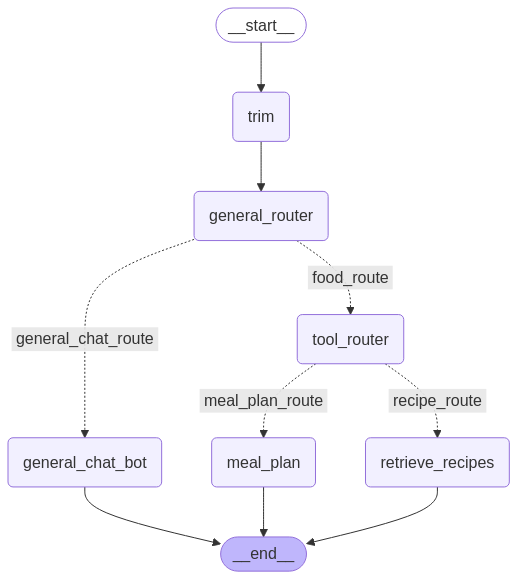

In [156]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Chat and testing

In [157]:
config = {"configurable": {"thread_id": "1"}}

In [158]:
# input_message = [HumanMessage(content="Hey")]
# output = app.invoke({"messages":input_message},config=config)
# output["messages"][-1].pretty_print()

In [159]:
input_message = [HumanMessage(content="How to make butter chicken"),
                 HumanMessage(content="Help me createa meal plan for the week"),
                 HumanMessage(content="What is the capital of France")]

for input_m in input_message:
    output = app.invoke({"messages":input_m},config=config)
    output["messages"][-1].pretty_print()

reached general state
---ROUTE QUESTION (GENERAL)---
message:  How to make butter chicken
source:  food
---ROUTE QUESTION TO FOOD---
reached food state
---ROUTE QUESTION (TOOLS)---
message:  How to make butter chicken
source:  recipe
---ROUTE QUESTION TO RECIPE---
---RETRIEVE---
retrieved using the prompt:  How to make butter chicken
retrieved:  [Document(id='0a5a899762784e62804702b8cc9a6b95', metadata={'description': "This easy cake recipe requires just 7 ingredients and tastes like you spent hours making it, even though it's out of the oven in under an hour.", 'language': 'en', 'source': 'https://www.allrecipes.com/recipe/17481/simple-white-cake/?print', 'title': 'Simple White Cake Recipe'}, page_content="Worth the effort\nVery light, very great. This is my second time trying this recipe and it turned out just as amazing as the first time. Very beginner friendly, today I added some nuts on top. \n\n \n05\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nSayeh Majzoob\n\n\n\n\n\n\n\n\n\n\n